# Differencial equation

This function g models the effect of the equation:
$$\frac{\partial \sigma_i}{\partial t}  = -\frac{\partial V}{\partial \sigma_i} +
\sum_j J_{ij} \sigma_j + h_i\sigma_i + \xi_i(t)$$

with $V = \lambda (\sigma_i^2 - 1)^2$ so that $\frac{\partial V}{\partial\sigma_i} = 4\lambda(\sigma_i^2 - 1)\sigma_i$. This term is added to ensure that $\sigma_i$ decays exponentially to either $\pm 1$ within a time $\tau \sim \frac{1}{\lambda}$

The $\xi_i(t)$ term represents Gaussian White Noise

$$ \langle \xi_i(t) \xi_j(t') \rangle = 2T\delta_{ij}\delta(t-t')$$
i.e., $\xi_i(t)$ follows a $N(0, 2T)$, there is no correlation between the noise of different spins  ($i \neq j$) and the process is Markovian and therefore has no memory (the correlation is only nonzero when $t = t'$)

# Finite differences

Now we have to translate this differential equation into some finite difference equation. Since the neural network works with integer time increments, the exponential decay dynamics must be fast in times of order 1 and the Ising dynamics must be "slow"

$$\sigma_i(t+1) - \sigma_i(t) = -4\lambda(\sigma_i^2 - 1)\sigma_i + \epsilon\left( \sum_j J_{ij} \sigma_j + h_i\sigma_i + \xi_i(t) \right)$$

$$g (\sigma_i(t)) = \sigma_i(t+1)= -4\lambda(\sigma_i^2 - 1)\sigma_i + \epsilon\left( \sum_j J_{ij} \sigma_j + h_i\sigma_i + \xi_i(t) \right) + \sigma_i(t)$$

for example $\lambda = 1/4$ and $\epsilon = 0.1$

In [1]:
import numpy as np
# define functions and parameters T, cexp
# you have to rerun this cell if you want to change your parameters
T = 0.0
cexp = 1.0
eps = 0.1
def g(state_t0, weights):
    h = np.dot(weights, state_t0)
    xi = np.sqrt(2*T)*np.random.randn(np.size(state_t0))
    return -cexp*(state_t0**2 - 1)*state_t0 + eps*(h + xi) + state_t0

$$J_{ij} = \frac{1}{N}\sum_{\lambda=1}^K m_i^{(\lambda)} m_j^{(\lambda)}$$

$m_i^{(\lambda)}$ can be written as a slice of a [Hadamard matrix](https://en.wikipedia.org/wiki/Hadamard_matrix), since the patterns have to be orthogonal, $\sum_i m_i^{(\lambda)} m_i^{(\lambda')} = 0 $ if $\lambda \neq \lambda'$
$i = 1..N$ and $\lambda = 1..K$. $N = L^2$ is the size of the newtork and $K$ is the number of stationary states of the system (memory patterns)

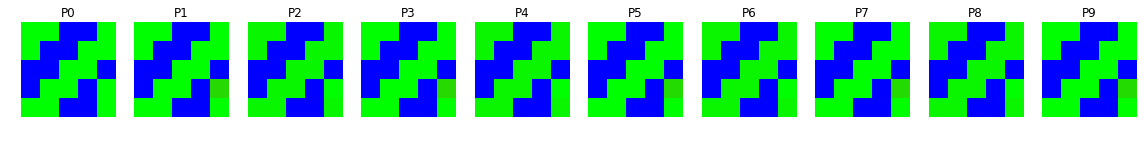

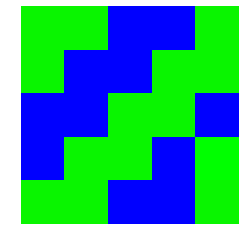

Final state


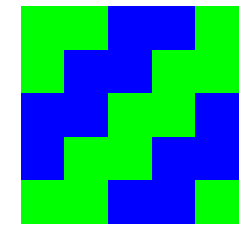

Stationary state


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from neurodynex.hopfield_network import network, pattern_tools, plot_tools
from scipy.linalg import hadamard

L = 5 # size of the newtork
N = L**2
had_size = 2**np.ceil(np.log2(N))
# had_size has to be a power of two
H = hadamard(had_size) # Orthogonal patterns
K = 1 # number of stationary states of the system (memory patterns)
H = H[0:N, 2:3]

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons=N)
# instantiate a pattern factory
factory = pattern_tools.PatternFactory(L, L)

# einstein summation convention, sum in lambda index
hopfield_net.weights = 1/N*np.einsum('ik,jk->ij', H, H)

# set user defined function to update the state
hopfield_net.set_dynamics_to_user_function(g)
# hopfield_net.set_dynamics_sign_sync()

# from this initial state, let the network dynamics evolve.
# state = hopfield_net.state
# state = factory.reshape_patterns([state])[0]
# plot_tools.plot_pattern(state)
# print('Initial state')
# hopfield_net.run(nr_steps=1)
# state = hopfield_net.state
# state = factory.reshape_patterns([state])[0]
# plot_tools.plot_pattern(state)
# print('Final state')

stationary = np.squeeze(H) # this should be an stationary state

hopfield_net.state = pattern_tools.flip_n(stationary, nr_of_flips=1)
nsteps = 50
states = hopfield_net.run_with_monitoring(nr_steps=nsteps)
# TODO large nr_steps fails because numbers blow up (see cell below)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states[0:nsteps:round(nsteps/10)])
# plot the states of the network (10 equispaced states)
old = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (20, 20)
plot_tools.plot_pattern_list(states_as_patterns)
plt.rcParams["figure.figsize"] = old

# plot final state and to compare it against the stationary state
plot_tools.plot_pattern(np.reshape(states[-1], (L, L)))
print('Final state')
plot_tools.plot_pattern(np.reshape(H, (L, L)))
print('Stationary state')

In [69]:
states[-1] # final state
# TODO the spins blow up and increase with each update. they don't converge to +/- 1

array([-1.01072948,  0.98454115,  1.01072948, -0.98454115,  0.98454115,
       -1.01072948,  1.01072948, -0.98454115,  0.98454115, -1.01072948,
       -0.98454115,  1.01072948, -1.01072948,  0.98454115,  1.01072948,
       -0.98454115,  0.98454115, -1.01072948,  1.01072948, -0.98454115,
        0.98454115, -1.01072948,  1.01072948,  1.01072948,  0.98454115])

[6.0, 4.0]

In [14]:
np.shape(hopfield_net.state)

(25,)